In [1]:
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, DataLoader
from torchmetrics.segmentation import MeanIoU
import torch
# import torchvision.models.segmentation as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
data_path = "/kaggle/input/a4-data/dataset_224"
train_images_path = os.path.join(data_path, "train", "images")
train_labels_path = os.path.join(data_path, "train", "labels")

test_images_path = os.path.join(data_path, "test", "images")
test_labels_path = os.path.join(data_path, "test", "labels")

Image shape: (224, 224, 3)
Mask shape: (224, 224, 3)
Unique values in mask: [ 0  1  2  3  5  6  7  8  9 10 11]


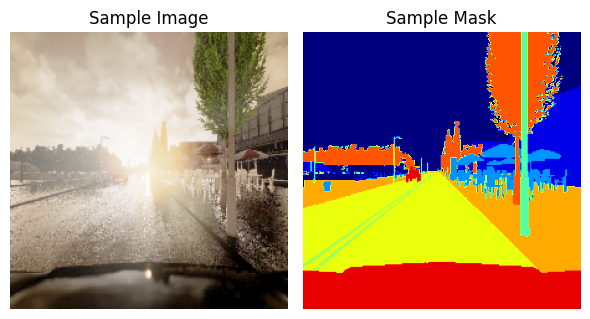

In [3]:
sample_img = os.listdir(train_images_path)[22]
sample_mask = os.listdir(train_labels_path)[22]

# Open the image and mask
img = Image.open(os.path.join(train_images_path, sample_img))
mask = Image.open(os.path.join(train_labels_path, sample_mask))

# Convert to numpy arrays
img_np = np.array(img)
mask_np = np.array(mask)

print(f"Image shape: {img_np.shape}")
print(f"Mask shape: {mask_np.shape}")
print(f"Unique values in mask: {np.unique(mask_np)}")  

fig, axes = plt.subplots(1, 2, figsize=(6, 6))

axes[0].imshow(img_np)
axes[0].set_title("Sample Image")
axes[0].axis("off")

axes[1].imshow(mask_np[:, :, 0], cmap="jet")  # We only need the first channel (grayscale)
axes[1].set_title("Sample Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [4]:
mask_np = np.array(mask)
unique_colors = np.unique(mask_np.reshape(-1, 3), axis=0)
print("Unique RGB colors in the mask:", unique_colors)

Unique RGB colors in the mask: [[ 0  0  0]
 [ 1  0  0]
 [ 2  0  0]
 [ 3  0  0]
 [ 5  0  0]
 [ 6  0  0]
 [ 7  0  0]
 [ 8  0  0]
 [ 9  0  0]
 [10  0  0]
 [11  0  0]]


In [5]:
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_filenames = sorted(os.listdir(img_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        # Load image & mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # Convert to numpy
        image = np.array(image)
        mask = np.array(mask)[:, :, 0]  # Take only first channel

        # Convert to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0  # Normalize to [0,1]
        mask = torch.tensor(mask, dtype=torch.long)  # Class indices (0-12)

        return image, mask

In [6]:
# Define dataset
dataset = SegmentationDataset(train_images_path, train_labels_path)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

test_dataset = SegmentationDataset(test_images_path, test_labels_path)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

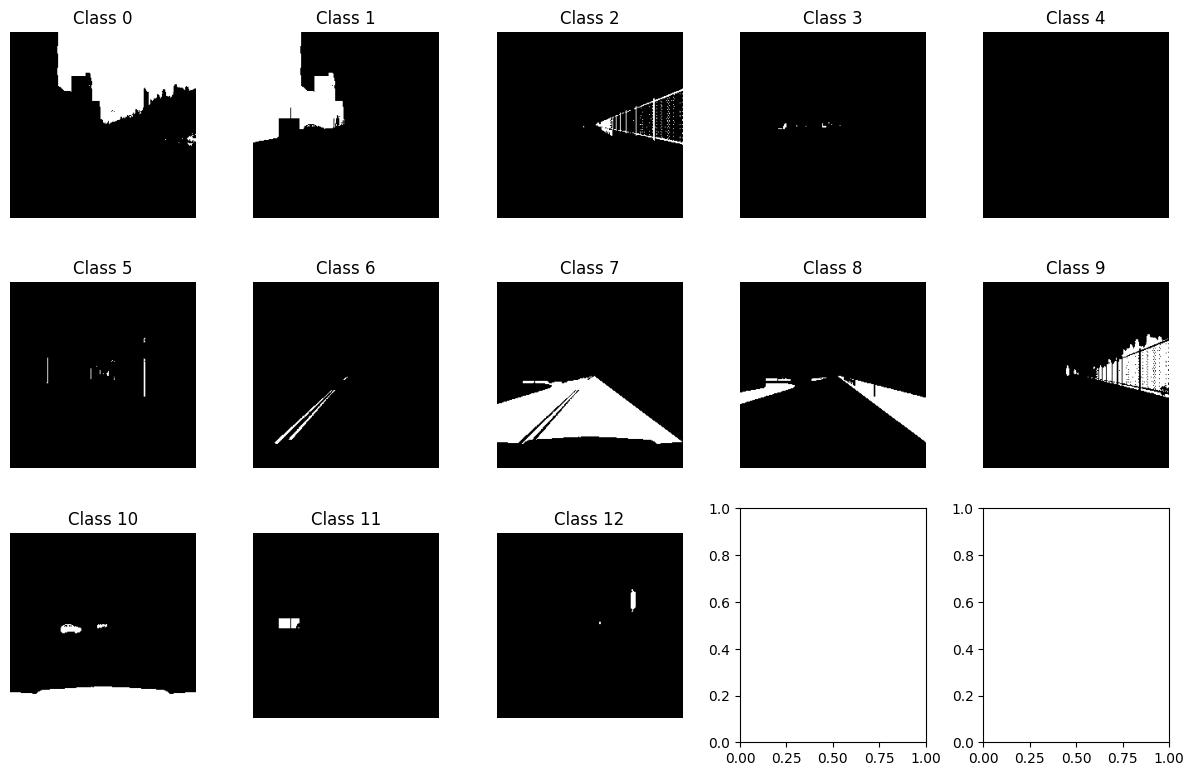

In [7]:
def visualize_classes(mask):
    num_classes = 13
    fig, axes = plt.subplots(3, 5, figsize=(12, 8))  # 3x5 grid

    for i in range(num_classes):
        binary_mask = (mask == i).astype(np.uint8)  # Binary mask for class i
        ax = axes[i // 5, i % 5]
        ax.imshow(binary_mask, cmap="gray")
        ax.set_title(f"Class {i}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
mask_sample = dataset[22][1].numpy()  # Get first mask from dataset
visualize_classes(mask_sample)

Batch image shape: torch.Size([8, 3, 224, 224])
Batch mask shape: torch.Size([8, 224, 224])
Unique values in masks: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])


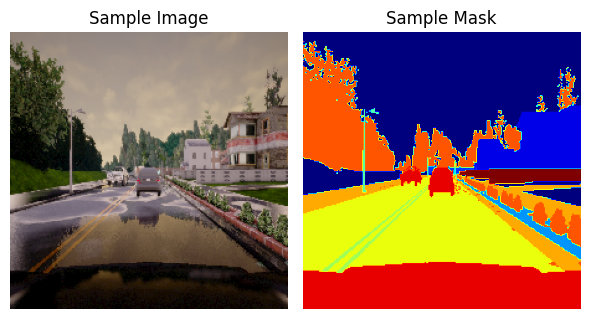

In [8]:
# Get one batch from train_loader
batch = next(iter(train_loader))
images, masks = batch

print(f"Batch image shape: {images.shape}")  
print(f"Batch mask shape: {masks.shape}")    
print(f"Unique values in masks: {torch.unique(masks)}") 

# Visualize a sample from the batch
fig, axes = plt.subplots(1, 2, figsize=(6, 6))
axes[0].imshow(images[0].permute(1, 2, 0))  # Convert CHW -> HWC
axes[0].set_title("Sample Image")
axes[0].axis("off")

axes[1].imshow(masks[0], cmap="jet")
axes[1].set_title("Sample Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [9]:
print(f"Total dataset size: {len(dataset)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Total dataset size: 2000
Train dataset size: 1600
Validation dataset size: 400
Test dataset size: 500


In [10]:
for batch_idx, (images, masks) in enumerate(train_loader):
    print(f"Batch {batch_idx+1} - Image Shape: {images.shape}, Mask Shape: {masks.shape}")
    if batch_idx == 2:  
        break

Batch 1 - Image Shape: torch.Size([8, 3, 224, 224]), Mask Shape: torch.Size([8, 224, 224])
Batch 2 - Image Shape: torch.Size([8, 3, 224, 224]), Mask Shape: torch.Size([8, 224, 224])
Batch 3 - Image Shape: torch.Size([8, 3, 224, 224]), Mask Shape: torch.Size([8, 224, 224])


### Function to visualize predictions

In [11]:
def visualize_predictions(model):
    model.eval()
    images, masks = next(iter(test_loader))
    images, masks = images.to(device), masks.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
    
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    
    for i in range(3):
        axes[i, 0].imshow(images[i].cpu().permute(1, 2, 0))
        axes[i, 0].set_title("Input Image")
        
        axes[i, 1].imshow(masks[i].cpu(), cmap="jet")
        axes[i, 1].set_title("Ground Truth")
        
        axes[i, 2].imshow(preds[i].cpu(), cmap="jet")
        axes[i, 2].set_title("Predicted Mask")
    plt.tight_layout()
    plt.show()

In [12]:
def plot_losses(train_losses, val_losses):
    # Assume train_losses and val_losses are lists storing loss values per epoch
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Training Loss", marker="o")
    plt.plot(val_losses, label="Validation Loss", marker="s")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
def train_model(model, train_loader, val_loader, num_epochs=40, patience=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    # for batch_idx, (inputs, masks) in enumerate(train_loader):
    #     inputs, masks = inputs.to(device), masks.to(device)
    
        # # 🐛 Debug prints
        # print(f"Batch {batch_idx}")
        # print(f"Inputs shape: {inputs.shape}")       # e.g., [B, 3, 256, 256]
        # print(f"Masks shape: {masks.shape}")         # e.g., [B, 256, 256]
        # print(f"Masks dtype: {masks.dtype}")         # should be torch.long
        # print(f"Unique mask values: {torch.unique(masks)}")  # should be within [0, n_classes - 1]

    for epoch in range(num_epochs):
        # --------- Training ---------
        model.train()
        total_train_loss = 0

        for images, masks in train_loader:
            # print("Mask shape:", masks.shape)
            # print("Mask dtype:", masks.dtype)
            # print("Unique values in mask:", torch.unique(masks))

            images, masks = images.to(device), masks.to(device)
            if isinstance(model, FCN32s):
                masks = F.interpolate(masks.unsqueeze(1).float(), size=(32, 32), mode="nearest").squeeze(1).long()

            # if(model == "tuned_fcn16"):
            #     masks = F.interpolate(masks.unsqueeze(1).float(), size=(448, 448), mode="nearest").squeeze(1).long()
            # masks = F.interpolate(masks.unsqueeze(1).float(), size=(896, 896), mode="nearest").squeeze(1).long()
            
            optimizer.zero_grad()
            outputs = model(images)
            # print("Output shape:", outputs.shape)
            # print("Mask shape:", masks.shape)
            # print("Mask dtype:", masks.dtype)
            if isinstance(model, FCN16sTuned):
                # Resize mask to output shape
                masks = F.interpolate(masks.unsqueeze(1).float(), size=outputs.shape[-2:], mode="nearest").squeeze(1).long()
            if isinstance(model, FCN8sTuned):
                masks = F.interpolate(masks.unsqueeze(1).float(), size=outputs.shape[-2:], mode="nearest").squeeze(1).long()
            assert outputs.shape[-2:] == masks.shape[-2:], f"Shape mismatch: outputs {outputs.shape}, masks {masks.shape}"
            # print("Output shape:", outputs.shape)
            # print("Target shape:", masks.shape)
            # print("Max target value:", masks.max().item())
            # print("Min target value:", masks.min().item())
            # print("Num classes:", outputs.shape[1])

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # --------- Validation ---------
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                if isinstance(model, FCN32s):
                    masks = F.interpolate(masks.unsqueeze(1).float(), size=(32, 32), mode="nearest").squeeze(1).long()
                # if(model == "tuned_fcn16"):
                #     masks = F.interpolate(masks.unsqueeze(1).float(), size=(448, 448), mode="nearest").squeeze(1).long()
                outputs = model(images)
                if isinstance(model, FCN16sTuned):
                # Resize mask to output shape
                    masks = F.interpolate(masks.unsqueeze(1).float(), size=outputs.shape[-2:], mode="nearest").squeeze(1).long()
                if isinstance(model, FCN8sTuned):
                    masks = F.interpolate(masks.unsqueeze(1).float(), size=outputs.shape[-2:], mode="nearest").squeeze(1).long()
                assert outputs.shape[-2:] == masks.shape[-2:], f"Shape mismatch: outputs {outputs.shape}, masks {masks.shape}"
                loss = criterion(outputs, masks)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # --------- Early Stopping Check ---------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()  # Save best model
        else:
            patience_counter += 1
            print(f"No improvement in val loss for {patience_counter} epochs.")

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

    # Load best model weights before returning
    model.load_state_dict(best_model_state)
    return train_losses, val_losses
    # return model

In [14]:
def evaluate_model(model, test_loader):
    metric = MeanIoU(num_classes=13).to(device)
    model.eval()
    
    iou_scores = []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            if isinstance(model, FCN32s):
                masks = F.interpolate(masks.unsqueeze(1).float(), size=(32, 32), mode="nearest").squeeze(1).long()
            outputs = model(images)
            if isinstance(model, FCN16sTuned):
                # Resize mask to output shape
                masks = F.interpolate(masks.unsqueeze(1).float(), size=outputs.shape[-2:], mode="nearest").squeeze(1).long()
            if isinstance(model, FCN8sTuned):
                masks = F.interpolate(masks.unsqueeze(1).float(), size=outputs.shape[-2:], mode="nearest").squeeze(1).long()
            preds = torch.argmax(outputs, dim=1)  # Get class with highest probability
            
            iou = metric(preds, masks)
            iou_scores.append(iou.item())
    
    print(f"Mean IoU on Test Set: {np.mean(iou_scores):.4f}")

In [15]:
class FCN32s(nn.Module):
    def __init__(self, num_classes=13):
        super(FCN32s, self).__init__()

        # Load pre-trained VGG16
        vgg16 = models.vgg16(pretrained=True)
        self.features = vgg16.features  # Feature extractor (convolutions)

        # Fully Convolutional layers (instead of FC layers in VGG)
        self.conv6 = nn.Conv2d(512, 4096, kernel_size=7)
        self.conv7 = nn.Conv2d(4096, 4096, kernel_size=1)
        self.score_fr = nn.Conv2d(4096, num_classes, kernel_size=1)  # Output scores

        # Upsampling
        self.upsample = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=32)

    def forward(self, x):
        x = self.features(x)  # Pass through VGG16 feature extractor
        x = F.relu(self.conv6(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.conv7(x))
        x = F.dropout(x, 0.5)
        x = self.score_fr(x)
        x = self.upsample(x)  # Upsample to original image size
        return x

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
model_fcn32 = FCN32s(num_classes=13)
# model_fcn32 = nn.DataParallel(model_fcn32)  # Wrap model for multi-GPU
model_fcn32.to(device)

criterion = nn.CrossEntropyLoss()

In [21]:
train_losses, val_losses = train_model(model_fcn32, train_loader, val_loader)

Epoch 1/40 | Train Loss: 0.8641 | Val Loss: 0.6592
Epoch 2/40 | Train Loss: 0.5938 | Val Loss: 0.5290
Epoch 3/40 | Train Loss: 0.4992 | Val Loss: 0.4747
Epoch 4/40 | Train Loss: 0.4593 | Val Loss: 0.4460
Epoch 5/40 | Train Loss: 0.4294 | Val Loss: 0.4218
Epoch 6/40 | Train Loss: 0.4067 | Val Loss: 0.4018
Epoch 7/40 | Train Loss: 0.3894 | Val Loss: 0.3885
Epoch 8/40 | Train Loss: 0.3713 | Val Loss: 0.3709
Epoch 9/40 | Train Loss: 0.3539 | Val Loss: 0.3573
Epoch 10/40 | Train Loss: 0.3394 | Val Loss: 0.3465
Epoch 11/40 | Train Loss: 0.3263 | Val Loss: 0.3405
Epoch 12/40 | Train Loss: 0.3176 | Val Loss: 0.3308
Epoch 13/40 | Train Loss: 0.3101 | Val Loss: 0.3240
Epoch 14/40 | Train Loss: 0.3041 | Val Loss: 0.3194
Epoch 15/40 | Train Loss: 0.2991 | Val Loss: 0.3173
Epoch 16/40 | Train Loss: 0.2952 | Val Loss: 0.3202
No improvement in val loss for 1 epochs.
Epoch 17/40 | Train Loss: 0.2916 | Val Loss: 0.3112
Epoch 18/40 | Train Loss: 0.2888 | Val Loss: 0.3081
Epoch 19/40 | Train Loss: 0.2850

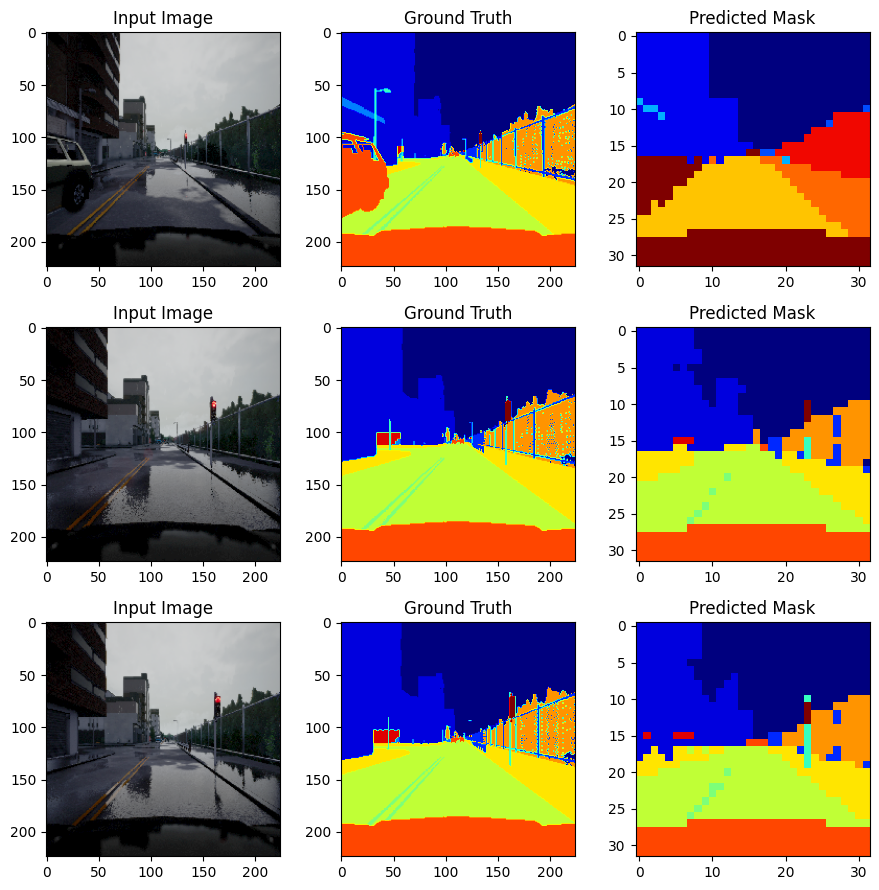

In [22]:
visualize_predictions(model_fcn32)

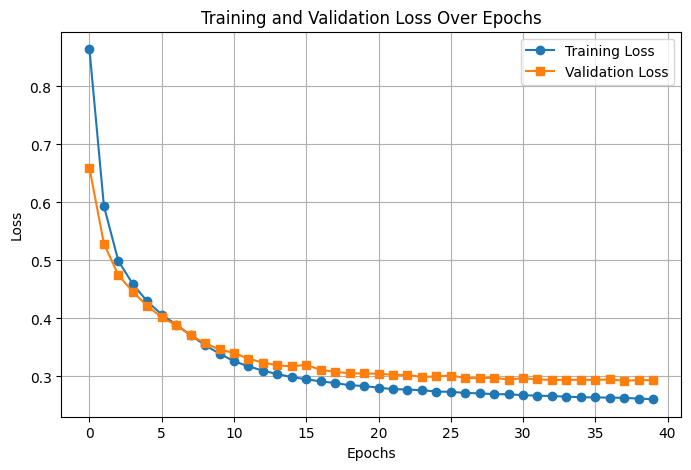

In [23]:
plot_losses(train_losses, val_losses)

In [24]:
evaluate_model(model_fcn32, test_loader)

Mean IoU on Test Set: 0.7148


### FCN 16

In [17]:
class FCN16s(nn.Module):
    def __init__(self, num_classes=13):
        super(FCN16s, self).__init__()
        
        vgg = models.vgg16(pretrained=True)  # Use VGG16 backbone
        features = list(vgg.features.children())  # Extract VGG layers

        # Encoder (VGG16 till Pool5)
        self.enc1 = nn.Sequential(*features[:17])  # Up to pool3
        self.enc2 = nn.Sequential(*features[17:24])  # Up to pool4
        self.enc3 = nn.Sequential(*features[24:])  # Up to pool5

        # 1x1 convolution to reduce channels before upsampling
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.score_pool5 = nn.Conv2d(512, num_classes, kernel_size=1)

        # Upsample layers
        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.upscore16 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=16, padding=8)

    def forward(self, x):
        pool3 = self.enc1(x)  # Output from Pool3
        pool4 = self.enc2(pool3)  # Output from Pool4
        pool5 = self.enc3(pool4)  # Output from Pool5

        score_pool5 = self.score_pool5(pool5)  # Reduce channels
        upscore2 = self.upscore2(score_pool5)  # Upsample by 2

        score_pool4 = self.score_pool4(pool4)  # Reduce channels
        fused = upscore2 + score_pool4  # Skip connection from Pool4

        upscore16 = self.upscore16(fused)  # Final upsampling

        return upscore16


model_fcn16 = FCN16s(num_classes=13).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 183MB/s]  


In [25]:
train_losses, val_losses = train_model(model_fcn16, train_loader, val_loader, num_epochs = 50)

Epoch 1/50 | Train Loss: 0.6559 | Val Loss: 0.2990
Epoch 2/50 | Train Loss: 0.2620 | Val Loss: 0.2407
Epoch 3/50 | Train Loss: 0.2206 | Val Loss: 0.2176
Epoch 4/50 | Train Loss: 0.1973 | Val Loss: 0.1969
Epoch 5/50 | Train Loss: 0.1797 | Val Loss: 0.1834
Epoch 6/50 | Train Loss: 0.1680 | Val Loss: 0.1757
Epoch 7/50 | Train Loss: 0.1588 | Val Loss: 0.1700
Epoch 8/50 | Train Loss: 0.1527 | Val Loss: 0.1621
Epoch 9/50 | Train Loss: 0.1468 | Val Loss: 0.1606
Epoch 10/50 | Train Loss: 0.1425 | Val Loss: 0.1558
Epoch 11/50 | Train Loss: 0.1375 | Val Loss: 0.1522
Epoch 12/50 | Train Loss: 0.1341 | Val Loss: 0.1504
Epoch 13/50 | Train Loss: 0.1316 | Val Loss: 0.1490
Epoch 14/50 | Train Loss: 0.1279 | Val Loss: 0.1454
Epoch 15/50 | Train Loss: 0.1254 | Val Loss: 0.1444
Epoch 16/50 | Train Loss: 0.1231 | Val Loss: 0.1429
Epoch 17/50 | Train Loss: 0.1222 | Val Loss: 0.1418
Epoch 18/50 | Train Loss: 0.1196 | Val Loss: 0.1415
Epoch 19/50 | Train Loss: 0.1172 | Val Loss: 0.1398
Epoch 20/50 | Train L

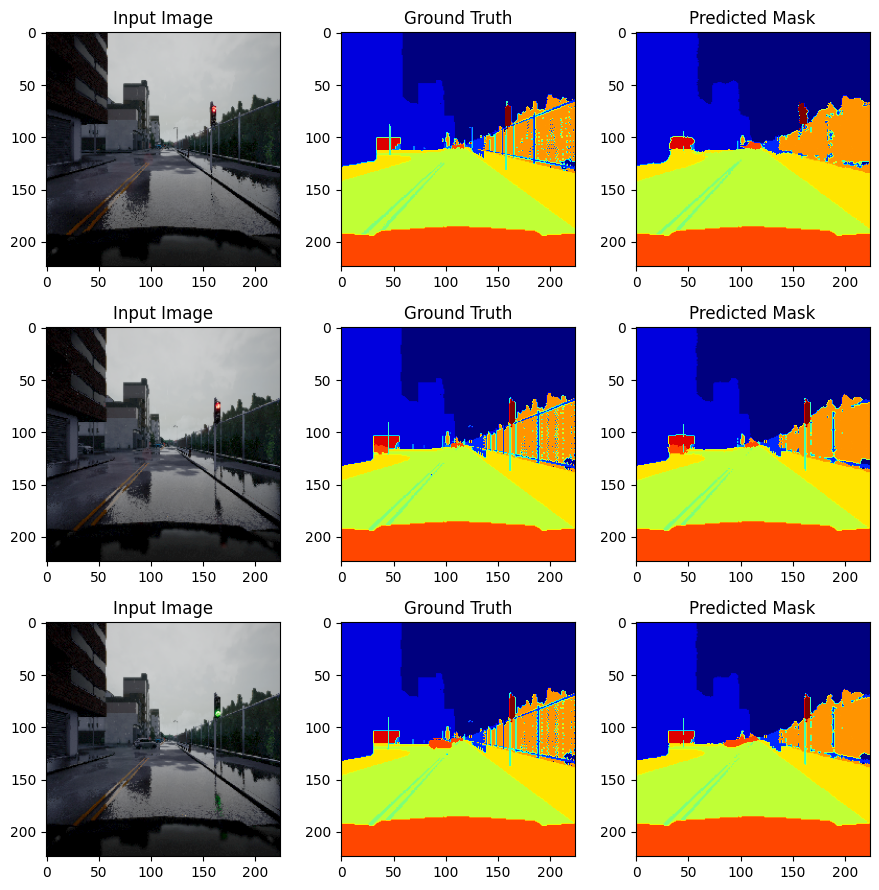

In [26]:
visualize_predictions(model_fcn16)

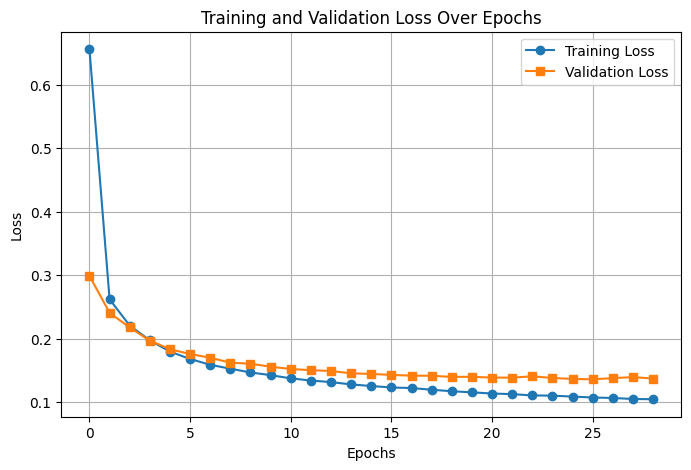

In [27]:
plot_losses(train_losses, val_losses)

In [31]:
evaluate_model(model_fcn16, test_loader)

Mean IoU on Test Set: 0.8234


### FCN 8

In [18]:
class FCN8s(nn.Module):
    def __init__(self, num_classes=13):
        super(FCN8s, self).__init__()
        
        vgg = models.vgg16(pretrained=True)
        features = list(vgg.features.children())

        self.enc1 = nn.Sequential(*features[:17])  # Up to pool3
        self.enc2 = nn.Sequential(*features[17:24])  # Up to pool4
        self.enc3 = nn.Sequential(*features[24:])  # Up to pool5

        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.score_pool5 = nn.Conv2d(512, num_classes, kernel_size=1)

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.upscore4 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4)

    def forward(self, x):
        pool3 = self.enc1(x)
        pool4 = self.enc2(pool3)
        pool5 = self.enc3(pool4)

        score_pool5 = self.score_pool5(pool5)
        upscore2 = self.upscore2(score_pool5)

        score_pool4 = self.score_pool4(pool4)
        fused_16s = upscore2 + score_pool4
        upscore4 = self.upscore4(fused_16s)

        score_pool3 = self.score_pool3(pool3)
        fused_8s = upscore4 + score_pool3

        upscore8 = self.upscore8(fused_8s)

        return upscore8

model_fcn8 = FCN8s(num_classes=13).to(device)

In [33]:
train_losses, val_losses = train_model(model_fcn8, train_loader, val_loader, num_epochs = 50)

Epoch 1/50 | Train Loss: 0.7830 | Val Loss: 0.3248
Epoch 2/50 | Train Loss: 0.2808 | Val Loss: 0.2521
Epoch 3/50 | Train Loss: 0.2285 | Val Loss: 0.2176
Epoch 4/50 | Train Loss: 0.1998 | Val Loss: 0.1991
Epoch 5/50 | Train Loss: 0.1810 | Val Loss: 0.1806
Epoch 6/50 | Train Loss: 0.1674 | Val Loss: 0.1690
Epoch 7/50 | Train Loss: 0.1580 | Val Loss: 0.1633
Epoch 8/50 | Train Loss: 0.1492 | Val Loss: 0.1577
Epoch 9/50 | Train Loss: 0.1429 | Val Loss: 0.1502
Epoch 10/50 | Train Loss: 0.1377 | Val Loss: 0.1471
Epoch 11/50 | Train Loss: 0.1339 | Val Loss: 0.1431
Epoch 12/50 | Train Loss: 0.1296 | Val Loss: 0.1418
Epoch 13/50 | Train Loss: 0.1267 | Val Loss: 0.1390
Epoch 14/50 | Train Loss: 0.1238 | Val Loss: 0.1365
Epoch 15/50 | Train Loss: 0.1211 | Val Loss: 0.1346
Epoch 16/50 | Train Loss: 0.1185 | Val Loss: 0.1317
Epoch 17/50 | Train Loss: 0.1176 | Val Loss: 0.1309
Epoch 18/50 | Train Loss: 0.1147 | Val Loss: 0.1293
Epoch 19/50 | Train Loss: 0.1123 | Val Loss: 0.1281
Epoch 20/50 | Train L

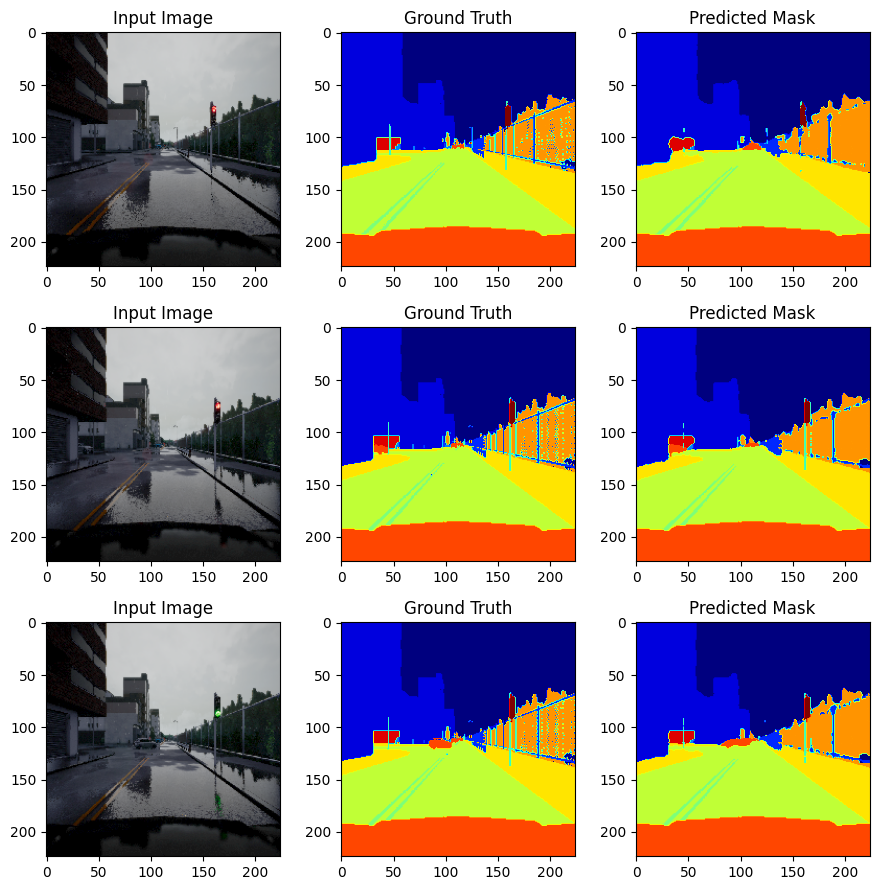

In [34]:
visualize_predictions(model_fcn8)

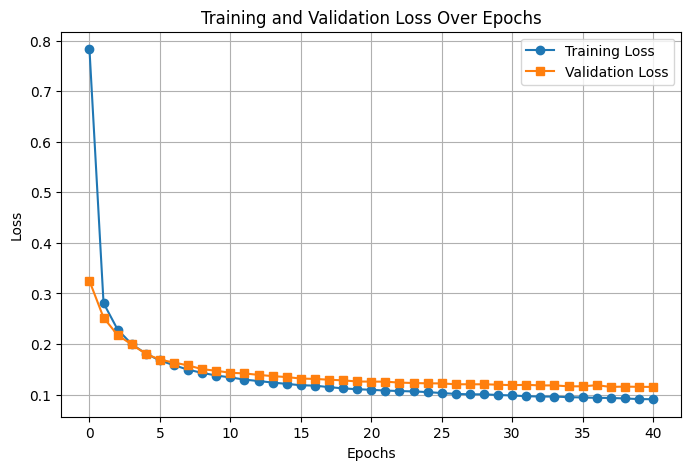

In [35]:
plot_losses(train_losses, val_losses)

In [36]:
evaluate_model(model_fcn8, test_loader)

Mean IoU on Test Set: 0.8419


# Fine Tuning

In [68]:
import torchvision
print(torchvision.__version__)

0.20.1+cu121


In [16]:
from torchvision.models.segmentation import fcn_resnet50
import torchvision.models.segmentation as segmentation_models

class FCN32sTuned(torch.nn.Module):
    def __init__(self, num_classes=13):
        super(FCN32sTuned, self).__init__()
        # self.fcn = models.fcn_resnet50(pretrained=True)  # Load pretrained model
        self.fcn = fcn_resnet50(weights="DEFAULT")
        
        # Modify classifier to output num_classes
        self.fcn.classifier[4] = torch.nn.Conv2d(512, num_classes, kernel_size=1)

    def forward(self, x):
        return self.fcn(x)['out']  # Only return segmentation output

class FCN16sTuned(torch.nn.Module):
    def __init__(self, num_classes=13):
        super(FCN16sTuned, self).__init__()
        # self.fcn = models.fcn_resnet50(pretrained=True)
        self.fcn = fcn_resnet50(weights="DEFAULT")

        # Modify classifier for 13 classes
        self.fcn.classifier[4] = torch.nn.Conv2d(512, num_classes, kernel_size=1)

        # Extra upsampling layer
        self.up16 = torch.nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fcn(x)['out']
        x = self.up16(x)  # Upsample predictions
        return x

class FCN8sTuned(torch.nn.Module):
    def __init__(self, num_classes=13):
        super(FCN8sTuned, self).__init__()
        # self.fcn = models.fcn_resnet50(pretrained=True)
        self.fcn = fcn_resnet50(weights="DEFAULT")

        # Modify classifier
        self.fcn.classifier[4] = torch.nn.Conv2d(512, num_classes, kernel_size=1)

        # Extra upsampling layers
        self.up16 = torch.nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.up8 = torch.nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fcn(x)['out']
        x = self.up16(x)  # First upsampling
        x = self.up8(x)   # Second upsampling
        return x

tuned_fcn32 = FCN32sTuned(num_classes=13).to(device)
tuned_fcn16 = FCN16sTuned(num_classes=13).to(device)
tuned_fcn8 = FCN8sTuned(num_classes=13).to(device)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:00<00:00, 194MB/s]  


## FCN 32

In [14]:
train_losses, val_losses = train_model(tuned_fcn32, train_loader, val_loader)

Epoch 1/40 | Train Loss: 0.5113 | Val Loss: 0.2862
Epoch 2/40 | Train Loss: 0.2429 | Val Loss: 0.2070
Epoch 3/40 | Train Loss: 0.1907 | Val Loss: 0.1808
Epoch 4/40 | Train Loss: 0.1673 | Val Loss: 0.1619
Epoch 5/40 | Train Loss: 0.1537 | Val Loss: 0.1534
Epoch 6/40 | Train Loss: 0.1456 | Val Loss: 0.1486
Epoch 7/40 | Train Loss: 0.1395 | Val Loss: 0.1432
Epoch 8/40 | Train Loss: 0.1343 | Val Loss: 0.1403
Epoch 9/40 | Train Loss: 0.1307 | Val Loss: 0.1369
Epoch 10/40 | Train Loss: 0.1273 | Val Loss: 0.1363
Epoch 11/40 | Train Loss: 0.1249 | Val Loss: 0.1326
Epoch 12/40 | Train Loss: 0.1227 | Val Loss: 0.1316
Epoch 13/40 | Train Loss: 0.1210 | Val Loss: 0.1305
Epoch 14/40 | Train Loss: 0.1198 | Val Loss: 0.1304
Epoch 15/40 | Train Loss: 0.1188 | Val Loss: 0.1293
Epoch 16/40 | Train Loss: 0.1177 | Val Loss: 0.1282
Epoch 17/40 | Train Loss: 0.1162 | Val Loss: 0.1283
No improvement in val loss for 1 epochs.
Epoch 18/40 | Train Loss: 0.1151 | Val Loss: 0.1266
Epoch 19/40 | Train Loss: 0.1145

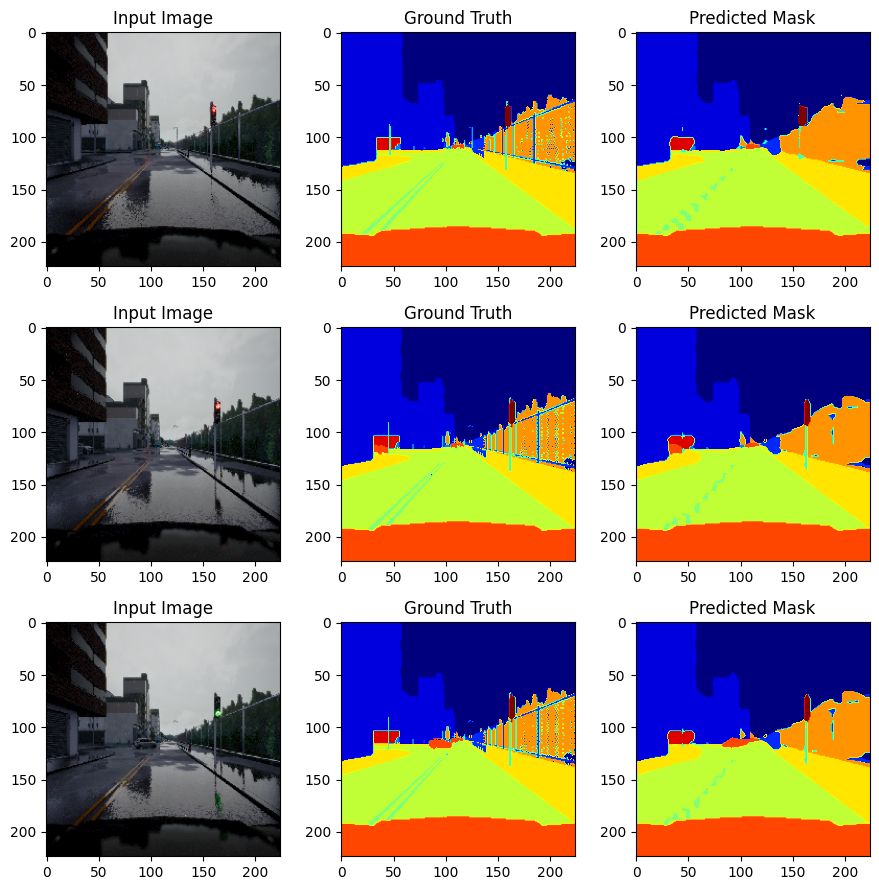

In [16]:
visualize_predictions(tuned_fcn32)

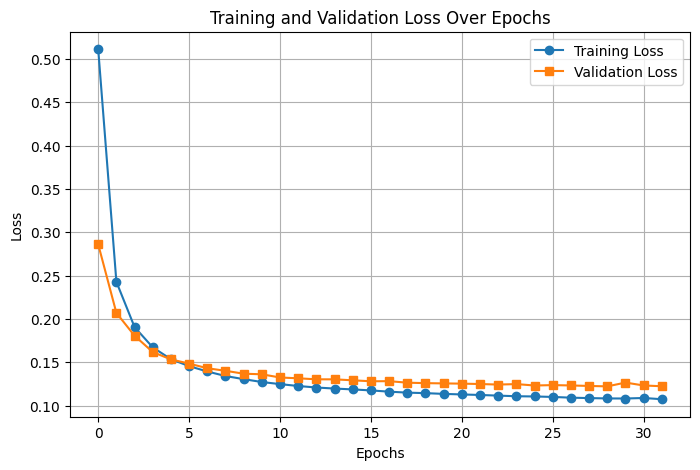

In [21]:
plot_losses(train_losses, val_losses)

In [24]:
evaluate_model(tuned_fcn32, test_loader)

Mean IoU on Test Set: 0.8293


### FCN 16

In [32]:
train_losses, val_losses = train_model(tuned_fcn16, train_loader, val_loader, num_epochs = 50)

Epoch 1/50 | Train Loss: 1.3200 | Val Loss: 0.4866
Epoch 2/50 | Train Loss: 0.3480 | Val Loss: 0.2734
Epoch 3/50 | Train Loss: 0.2438 | Val Loss: 0.2166
Epoch 4/50 | Train Loss: 0.1976 | Val Loss: 0.1834
Epoch 5/50 | Train Loss: 0.1728 | Val Loss: 0.1664
Epoch 6/50 | Train Loss: 0.1580 | Val Loss: 0.1566
Epoch 7/50 | Train Loss: 0.1478 | Val Loss: 0.1485
Epoch 8/50 | Train Loss: 0.1411 | Val Loss: 0.1453
Epoch 9/50 | Train Loss: 0.1363 | Val Loss: 0.1414
Epoch 10/50 | Train Loss: 0.1329 | Val Loss: 0.1388
Epoch 11/50 | Train Loss: 0.1296 | Val Loss: 0.1368
Epoch 12/50 | Train Loss: 0.1275 | Val Loss: 0.1343
Epoch 13/50 | Train Loss: 0.1253 | Val Loss: 0.1333
Epoch 14/50 | Train Loss: 0.1234 | Val Loss: 0.1323
Epoch 15/50 | Train Loss: 0.1218 | Val Loss: 0.1311
Epoch 16/50 | Train Loss: 0.1205 | Val Loss: 0.1300
Epoch 17/50 | Train Loss: 0.1194 | Val Loss: 0.1290
Epoch 18/50 | Train Loss: 0.1181 | Val Loss: 0.1285
Epoch 19/50 | Train Loss: 0.1171 | Val Loss: 0.1284
Epoch 20/50 | Train L

([1.3199602638185024,
  0.34802554190158846,
  0.24383112773299218,
  0.19764391258358954,
  0.172820270806551,
  0.15802540495991707,
  0.1478357017785311,
  0.14113960966467856,
  0.1363262291252613,
  0.13286099348217248,
  0.12961152140051127,
  0.12750799752771855,
  0.12528077818453312,
  0.12339139841496945,
  0.12181156903505325,
  0.12049882803112269,
  0.1193975767865777,
  0.11806943919509649,
  0.11713607382029295,
  0.11707262381911278,
  0.11546693243086338,
  0.11454566098749637,
  0.11382494471967221,
  0.12860010705888272,
  0.12668229900300504],
 [0.486596457362175,
  0.27341478019952775,
  0.21664080142974854,
  0.18344278901815414,
  0.16641326993703842,
  0.15658431380987167,
  0.14846266597509383,
  0.14533057302236557,
  0.14138904258608817,
  0.13875161498785019,
  0.13683756187558174,
  0.13426941499114037,
  0.13327807754278184,
  0.13226028829813002,
  0.13110182359814643,
  0.12995011284947394,
  0.12898535326123237,
  0.12845990180969238,
  0.12840909630060

In [37]:
train_losses = [
    1.3200, 0.3480, 0.2438, 0.1976, 0.1728, 0.1580, 0.1478, 0.1411, 0.1363, 0.1329,
    0.1296, 0.1275, 0.1253, 0.1234, 0.1218, 0.1205, 0.1194, 0.1181, 0.1171, 0.1171,
    0.1155, 0.1145, 0.1138, 0.1286, 0.1267
]

val_losses = [
    0.4866, 0.2734, 0.2166, 0.1834, 0.1664, 0.1566, 0.1485, 0.1453, 0.1414, 0.1388,
    0.1368, 0.1343, 0.1333, 0.1323, 0.1311, 0.1300, 0.1290, 0.1285, 0.1284, 0.1272,
    0.1265, 0.1262, 0.1267, 0.1457, 0.1275
]

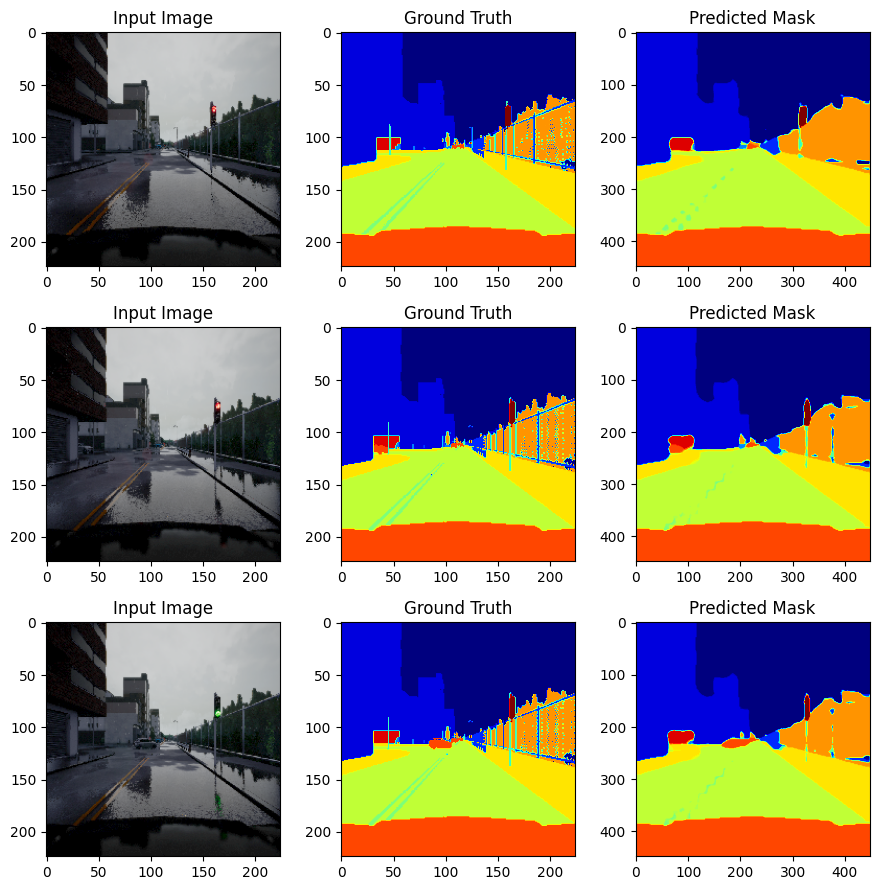

In [33]:
visualize_predictions(tuned_fcn16)

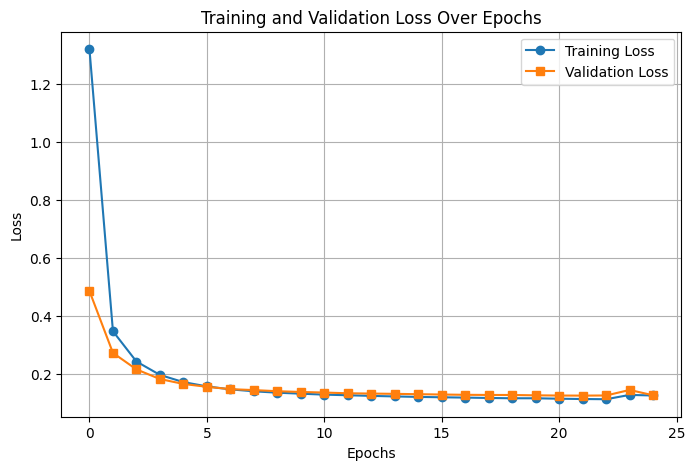

In [38]:
plot_losses(train_losses, val_losses)

In [36]:
evaluate_model(tuned_fcn16, test_loader)

Mean IoU on Test Set: 0.8277


### FCN 8

In [43]:
train_losses, val_losses = train_model(tuned_fcn8, train_loader, val_loader, num_epochs = 50)

Epoch 1/50 | Train Loss: 1.6688 | Val Loss: 0.8555
Epoch 2/50 | Train Loss: 0.5647 | Val Loss: 0.3353
Epoch 3/50 | Train Loss: 0.2917 | Val Loss: 0.2554
Epoch 4/50 | Train Loss: 0.2368 | Val Loss: 0.2255
Epoch 5/50 | Train Loss: 0.2098 | Val Loss: 0.1992
Epoch 6/50 | Train Loss: 0.1881 | Val Loss: 0.1842
Epoch 7/50 | Train Loss: 0.1738 | Val Loss: 0.1753
Epoch 8/50 | Train Loss: 0.1651 | Val Loss: 0.1689
Epoch 9/50 | Train Loss: 0.1575 | Val Loss: 0.1628
Epoch 10/50 | Train Loss: 0.1521 | Val Loss: 0.1587
Epoch 11/50 | Train Loss: 0.1475 | Val Loss: 0.1555
Epoch 12/50 | Train Loss: 0.1443 | Val Loss: 0.1538
Epoch 13/50 | Train Loss: 0.1404 | Val Loss: 0.1512
Epoch 14/50 | Train Loss: 0.1377 | Val Loss: 0.1477
Epoch 15/50 | Train Loss: 0.1356 | Val Loss: 0.1478
No improvement in val loss for 1 epochs.
Epoch 16/50 | Train Loss: 0.1336 | Val Loss: 0.1448
Epoch 17/50 | Train Loss: 0.1319 | Val Loss: 0.1442
Epoch 18/50 | Train Loss: 0.1323 | Val Loss: 0.1477
No improvement in val loss for 1

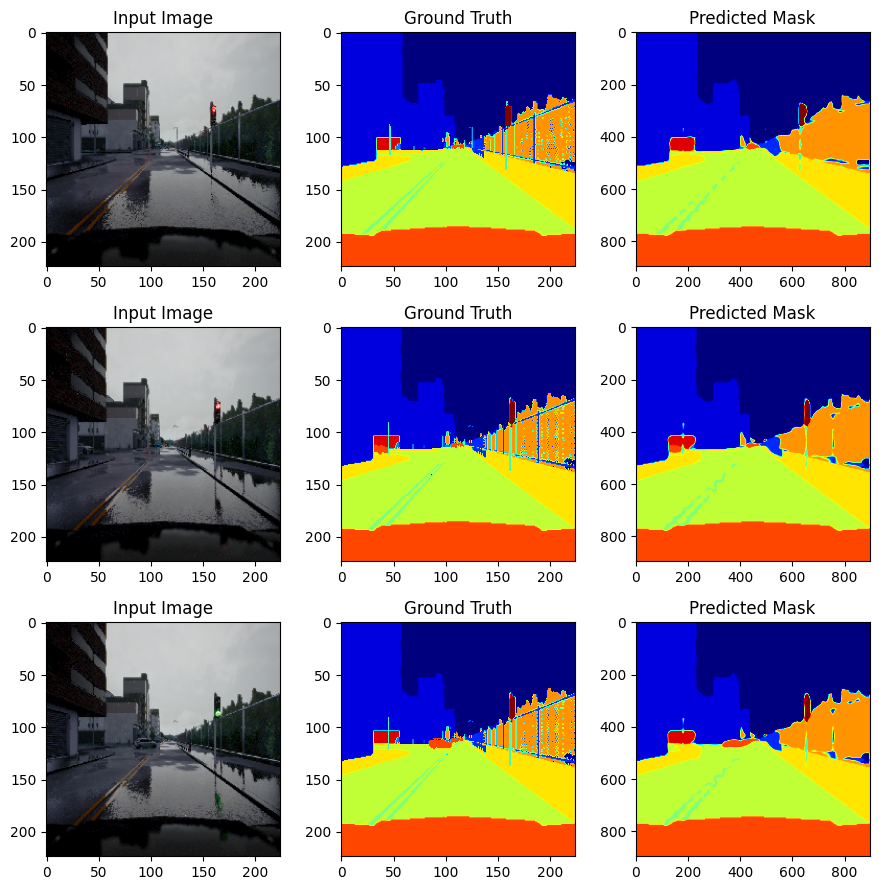

In [44]:
visualize_predictions(tuned_fcn8)

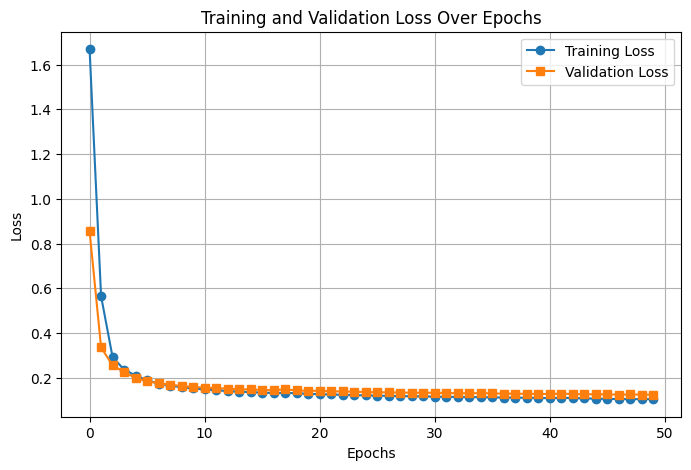

In [45]:
plot_losses(train_losses, val_losses)

In [19]:
evaluate_model(tuned_fcn16s, test_loader)

Mean IoU on Test Set: 0.847


# Performance comparison

In [1]:
import pandas as pd

# Define data
data = {
    "Variant": ["FCN32s", "FCN16s", "FCN8s"],
    "Frozen IoU": [0.7148, 0.8230, 0.8419],
    "Fine-tuned IoU": [0.8293, 0.8277, 0.8470]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display the table
df.style.set_caption("Mean IoU on Test Set for FCN Variants").format({"Frozen IoU": "{:.4f}", "Fine-tuned IoU": "{:.4f}"})

## Observations & Reasoning

1. **Overall Performance**:
   - FCN8s consistently performs best among all variants in both frozen and fine-tuned modes.
   - FCN32s shows the **largest improvement** from freezing to fine-tuning (~0.11 IoU jump), highlighting its sensitivity to training.

2. **Impact of Skip Connections**:
   - FCN8s and FCN16s both include more refined skip connections compared to FCN32s.
   - These connections help **preserve spatial details**, leading to better segmentation performance, especially on fine-grained boundaries.

3. **Frozen vs Fine-tuned**:
   - All models **improve with fine-tuning**, but:
     - FCN32s gains the most, likely because its coarser predictions benefit significantly from learning.
     - FCN16s improves slightly, indicating it was already performing well with frozen features.
     - FCN8s sees **marginal gains**, suggesting diminishing returns from fine-tuning due to already detailed representations.

4. **Best Trade-off**:
   - FCN8s (fine-tuned) offers the **best segmentation quality**, but may require more computation due to finer layers.
   - If efficiency is a concern, FCN16s (even frozen) gives a good balance of performance and speed.

## Observations

1. *Overall Performance*:
   - FCN8s consistently performs best among all variants in both frozen and fine-tuned modes.
   - FCN32s shows the **largest improvement** from freezing to fine-tuning (~0.11 IoU jump), highlighting its sensitivity to training.

2. **Impact of Skip Connections**:
   - FCN8s and FCN16s both include more refined skip connections compared to FCN32s.
   - These connections help **preserve spatial details**, leading to better segmentation performance, especially on fine-grained boundaries.

3. **Frozen vs Fine-tuned**:
   - All models **improve with fine-tuning**, but:
     - FCN32s gains the most, likely because its coarser predictions benefit significantly from learning.
     - FCN16s improves slightly, indicating it was already performing well with frozen features.
     - FCN8s sees **marginal gains**, suggesting diminishing returns from fine-tuning due to already detailed representations.

4. **Best Trade-off**:
   - FCN8s (fine-tuned) offers the **best segmentation quality**, but may require more computation due to finer layers.
   - If efficiency is a concern, FCN16s (even frozen) gives a good balance of performance and speed.

# 3. Using U-Net

In [ ]:
data_path = "/kaggle/input/unet-data/dataset_256"
train_images_path = os.path.join(data_path, "train", "images")
train_labels_path = os.path.join(data_path, "train", "labels")

test_images_path = os.path.join(data_path, "test", "images")
test_labels_path = os.path.join(data_path, "test", "labels")

# Get a sample image and label
sample_img = os.listdir(train_images_path)[22]
sample_mask = os.listdir(train_labels_path)[22]

# Open the image and mask
img = Image.open(os.path.join(train_images_path, sample_img))
mask = Image.open(os.path.join(train_labels_path, sample_mask))

# Convert to numpy arrays
img_np = np.array(img)
mask_np = np.array(mask)

print(f"Image shape: {img_np.shape}")
print(f"Mask shape: {mask_np.shape}")
print(f"Unique values in mask: {np.unique(mask_np)}")  

fig, axes = plt.subplots(1, 2, figsize=(6, 6))

axes[0].imshow(img_np)
axes[0].set_title("Sample Image")
axes[0].axis("off")

axes[1].imshow(mask_np[:, :, 0], cmap="jet")  # We only need the first channel (grayscale)
axes[1].set_title("Sample Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Define dataset
dataset = SegmentationDataset(train_images_path, train_labels_path)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

test_dataset = SegmentationDataset(test_images_path, test_labels_path)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

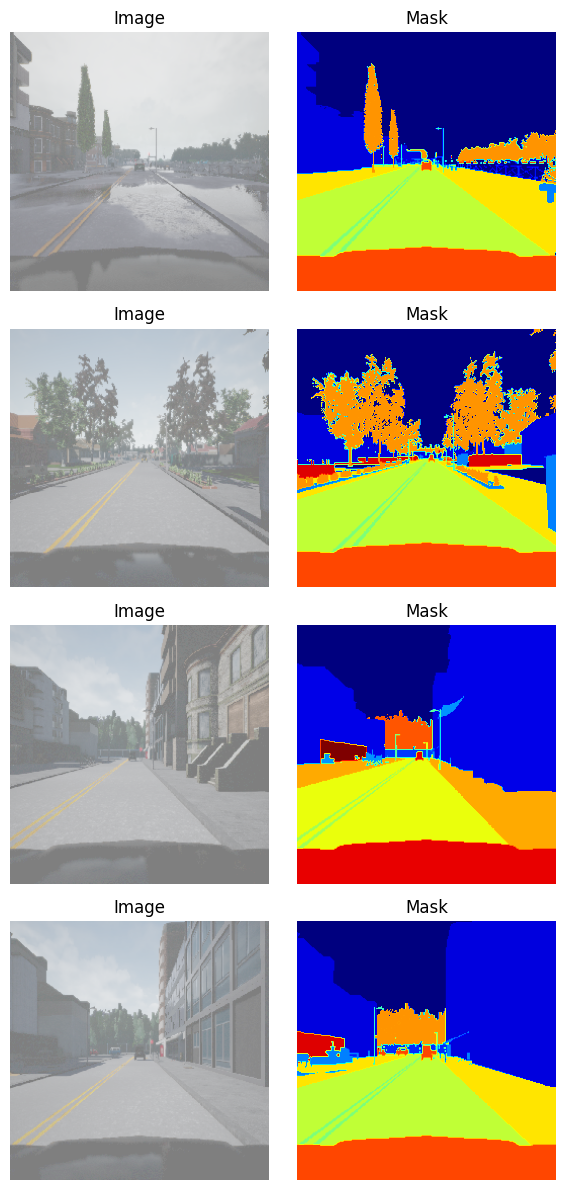

In [19]:
def visualize_batch(dataloader):
    images, masks = next(iter(dataloader))
    batch_size = images.size(0)

    fig, axes = plt.subplots(batch_size, 2, figsize=(6, 3 * batch_size))

    for i in range(batch_size):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5  # unnormalize
        img = np.clip(img, 0, 1)

        mask = masks[i].numpy()

        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask, cmap="jet")
        axes[i, 1].set_title("Mask")
        axes[i, 1].axis("off")
        
    plt.tight_layout()
    plt.show()

visualize_batch(train_loader)

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.relu = nn.ReLU(inplace=True)
        self.skip = nn.Identity()
        if residual and in_channels != out_channels:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.conv(x)
        if self.residual:
            x = self.skip(x)
            return self.relu(out + x)
        return self.relu(out)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, residual=False):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, residual=residual)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True, residual=False, attention=False):
        super().__init__()
        self.attention = attention
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            conv_in_channels = in_channels
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, 2, stride=2)
            conv_in_channels = in_channels

        self.conv = DoubleConv(conv_in_channels, out_channels, in_channels // 2, residual=residual)

        if attention:
            decoder_channels = in_channels // 2
            encoder_channels = in_channels // 2  # NOT out_channels
            self.attn = AttentionBlock(F_g=decoder_channels, F_l=encoder_channels)
            # self.attn = AttentionBlock(F_g=decoder_channels, F_l=encoder_channels)



    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        if self.attention:
            x2 = self.attn(x2, x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x):
        return self.conv(x)


class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_l, kernel_size=1),
            nn.BatchNorm2d(F_l)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_l, kernel_size=1),
            nn.BatchNorm2d(F_l)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_l, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class UNetVariants(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, variant='vanilla'):
        super().__init__()
        self.variant = variant
        self.bilinear = bilinear
        residual = variant == 'residual'
        attention = variant == 'attention'

        self.inc = DoubleConv(n_channels, 64, residual=residual)
        self.down1 = Down(64, 128, residual=residual)
        self.down2 = Down(128, 256, residual=residual)
        self.down3 = Down(256, 512, residual=residual)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor, residual=residual)

        self.up1 = Up(1024, 512 // factor, bilinear, residual=residual, attention=attention)
        self.up2 = Up(512, 256 // factor, bilinear, residual=residual, attention=attention)
        self.up3 = Up(256, 128 // factor, bilinear, residual=residual, attention=attention)
        self.up4 = Up(128, 64, bilinear, residual=residual, attention=attention)

        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
    
        # print("Encoder shapes:", x1.shape, x2.shape, x3.shape, x4.shape, x5.shape)
    
        if self.variant == 'no_skip':
            x = self.up1(x5, torch.zeros_like(x4))
            x = self.up2(x, torch.zeros_like(x3))
            x = self.up3(x, torch.zeros_like(x2))
            x = self.up4(x, torch.zeros_like(x1))
        else:
            x = self.up1(x5, x4)
            x = self.up2(x, x3)
            x = self.up3(x, x2)
            x = self.up4(x, x1)
    
        # print("Final decoder output:", x.shape)
        return self.outc(x)


In [22]:
# Vanilla U-Net
model_vanilla = UNetVariants(n_channels=3, n_classes=13, bilinear=True, variant='vanilla').to(device)

# No Skip Connections
model_noskip = UNetVariants(n_channels=3, n_classes=13, bilinear=True, variant='no_skip').to(device)

# Residual U-Net
model_residual = UNetVariants(n_channels=3, n_classes=13, bilinear=True, variant='residual').to(device)

# Attention U-Net
model_attention = UNetVariants(n_channels=3, n_classes=13, bilinear=True, variant='attention').to(device)

## Vanilla UNet

In [ ]:
# Mask shape: torch.Size([4, 256, 256])
# Mask dtype: torch.int64
# Unique values in mask: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
# Encoder shapes: torch.Size([4, 64, 256, 256]) torch.Size([4, 128, 128, 128]) torch.Size([4, 256, 64, 64]) torch.Size([4, 512, 32, 32]) torch.Size([4, 512, 16, 16])
# Final decoder output: torch.Size([4, 64, 256, 256])
# Output shape: torch.Size([4, 13, 256, 256])
# Target shape: torch.Size([4, 256, 256])
# Max target value: 12
# Min target value: 0
# Num classes: 13
# Mask shape: torch.Size([4, 256, 256])

In [30]:
train_losses, val_losses = train_model(model_vanilla, train_loader, val_loader)

Epoch 1/40 | Train Loss: 0.8366 | Val Loss: 0.4743
Epoch 2/40 | Train Loss: 0.3660 | Val Loss: 0.2807
Epoch 3/40 | Train Loss: 0.2349 | Val Loss: 0.1869
Epoch 4/40 | Train Loss: 0.1724 | Val Loss: 0.1652
Epoch 5/40 | Train Loss: 0.1396 | Val Loss: 0.1333
Epoch 6/40 | Train Loss: 0.1313 | Val Loss: 0.1077
Epoch 7/40 | Train Loss: 0.0994 | Val Loss: 0.0998
Epoch 8/40 | Train Loss: 0.0856 | Val Loss: 0.0797
Epoch 9/40 | Train Loss: 0.1043 | Val Loss: 0.1038
No improvement in val loss for 1 epochs.
Epoch 10/40 | Train Loss: 0.0787 | Val Loss: 0.0731
Epoch 11/40 | Train Loss: 0.0651 | Val Loss: 0.0651
Epoch 12/40 | Train Loss: 0.0593 | Val Loss: 0.0605
Epoch 13/40 | Train Loss: 0.0554 | Val Loss: 0.0568
Epoch 14/40 | Train Loss: 0.0798 | Val Loss: 0.0621
No improvement in val loss for 1 epochs.
Epoch 15/40 | Train Loss: 0.0519 | Val Loss: 0.0518
Epoch 16/40 | Train Loss: 0.0462 | Val Loss: 0.0483
Epoch 17/40 | Train Loss: 0.0435 | Val Loss: 0.0487
No improvement in val loss for 1 epochs.
Ep

([0.8365836988389492,
  0.3660137785226107,
  0.23486508943140508,
  0.17235316583886742,
  0.13957239486277104,
  0.1313081697002053,
  0.09936528619378805,
  0.08561529212631286,
  0.1043447191733867,
  0.07868425647728144,
  0.06513853936456143,
  0.059335633926093576,
  0.05540806166827679,
  0.0797984121646732,
  0.05191330621950328,
  0.04622937182895839,
  0.04353229993954301,
  0.06879236318171024,
  0.04831095260102302,
  0.04104600391816348,
  0.03830729248002172,
  0.03638085523620248,
  0.035596874472685155,
  0.036935642859898504],
 [0.47426523715257646,
  0.280735737234354,
  0.18691417396068574,
  0.1652308323979378,
  0.13330944895744323,
  0.10770001582801342,
  0.09981071591377258,
  0.07968649912625551,
  0.10379299409687519,
  0.07308251962065697,
  0.06510777607560157,
  0.060471609570086,
  0.056810904033482074,
  0.06212988663464784,
  0.05182233141735196,
  0.04832253657281399,
  0.04870006300508976,
  0.06951930861920118,
  0.047214813139289616,
  0.04339987723

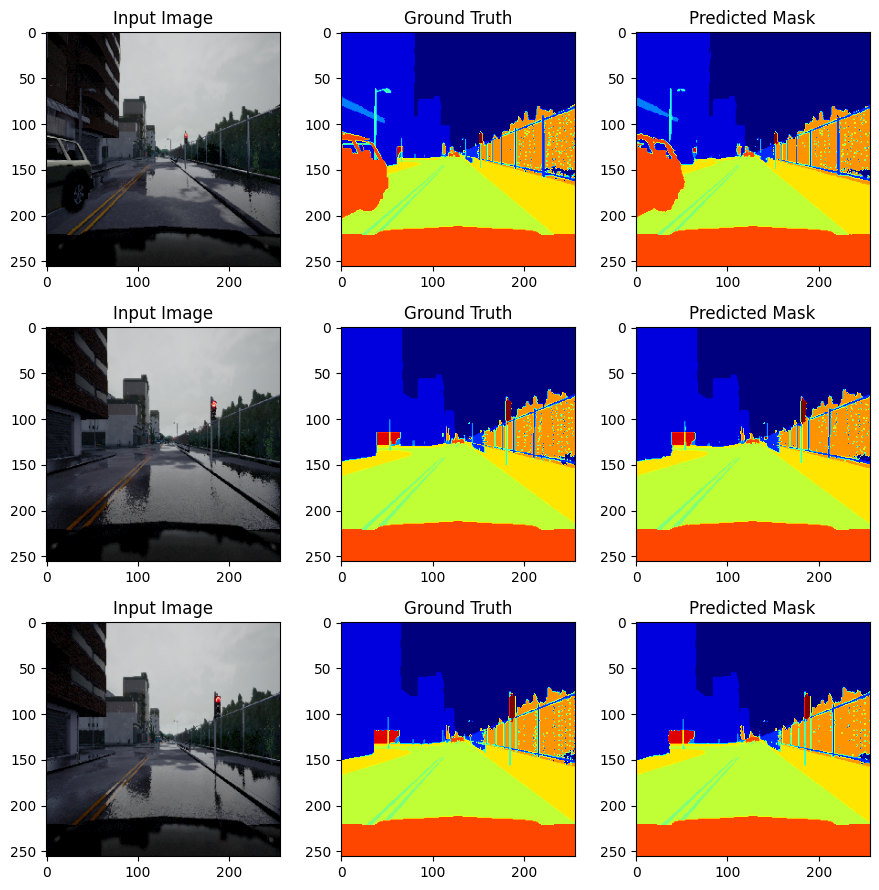

In [37]:
visualize_predictions(model_vanilla)

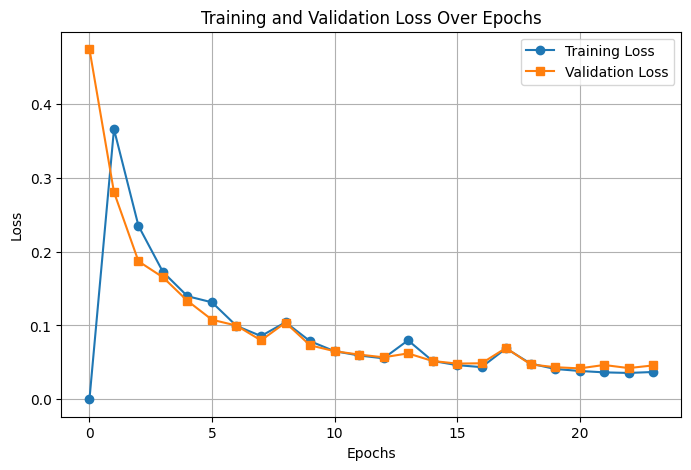

In [35]:
plot_losses(train_losses, val_losses)

In [38]:
evaluate_model(model_vanilla, test_loader)

Mean IoU on Test Set: 0.9053


## Removing skip connections

In [23]:
train_losses, val_losses = train_model(model_noskip, train_loader, val_loader)

Epoch 1/40 | Train Loss: 0.9819 | Val Loss: 0.6831
Epoch 2/40 | Train Loss: 0.5732 | Val Loss: 0.4833
Epoch 3/40 | Train Loss: 0.4175 | Val Loss: 0.3672
Epoch 4/40 | Train Loss: 0.3258 | Val Loss: 0.3031
Epoch 5/40 | Train Loss: 0.2764 | Val Loss: 0.2612
Epoch 6/40 | Train Loss: 0.2410 | Val Loss: 0.2895
No improvement in val loss for 1 epochs.
Epoch 7/40 | Train Loss: 0.2318 | Val Loss: 0.2479
Epoch 8/40 | Train Loss: 0.2022 | Val Loss: 0.1951
Epoch 9/40 | Train Loss: 0.1821 | Val Loss: 0.1833
Epoch 10/40 | Train Loss: 0.1672 | Val Loss: 0.1778
Epoch 11/40 | Train Loss: 0.1590 | Val Loss: 0.1661
Epoch 12/40 | Train Loss: 0.1710 | Val Loss: 0.1843
No improvement in val loss for 1 epochs.
Epoch 13/40 | Train Loss: 0.1496 | Val Loss: 0.1550
Epoch 14/40 | Train Loss: 0.1396 | Val Loss: 0.1504
Epoch 15/40 | Train Loss: 0.1341 | Val Loss: 0.1504
Epoch 16/40 | Train Loss: 0.1300 | Val Loss: 0.1466
Epoch 17/40 | Train Loss: 0.1263 | Val Loss: 0.1406
Epoch 18/40 | Train Loss: 0.1224 | Val Loss

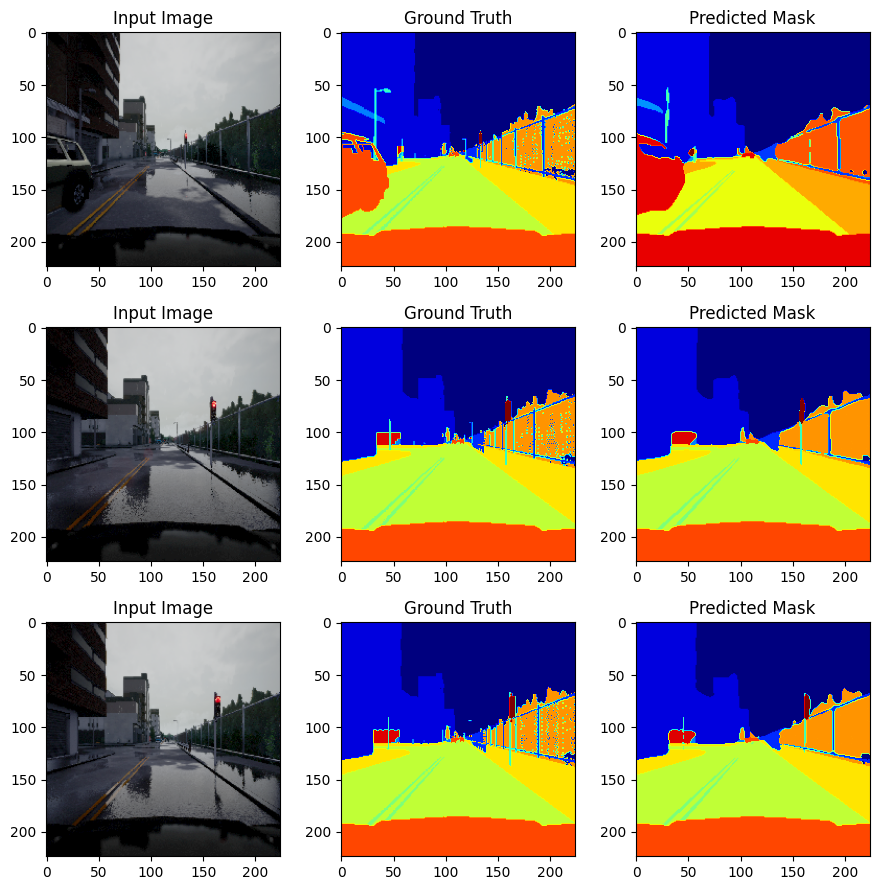

In [27]:
visualize_predictions(model_noskip)

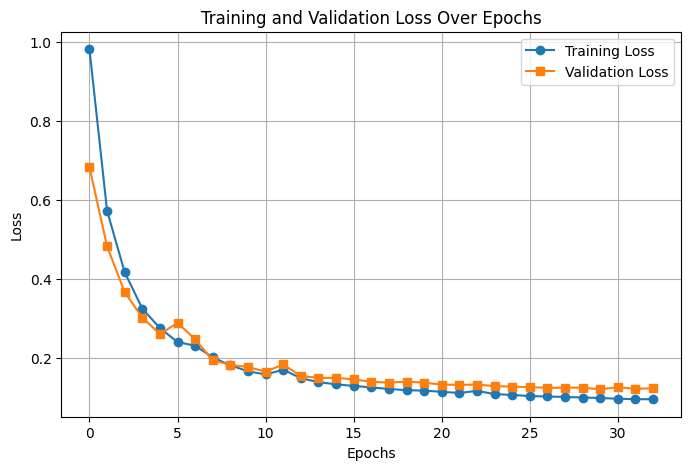

In [25]:
plot_losses(train_losses, val_losses)

In [28]:
evaluate_model(model_noskip, test_loader)

Mean IoU on Test Set: 0.8295


### Difference from U-Net

1. Very rough boundaries detected.
2. Finer details not preserved.
3. Fine objects in the image such as light pole, traffic light are not recognized. 

## Residual U-Net

In [28]:
# Residual U-Net
model_residual = UNetVariants(n_channels=3, n_classes=13, bilinear=True, variant='residual').to(device)

In [29]:
train_losses, val_losses = train_model(model_residual, train_loader, val_loader)

Epoch 1/40 | Train Loss: 0.5424 | Val Loss: 0.2327
Epoch 2/40 | Train Loss: 0.2054 | Val Loss: 0.1797
Epoch 3/40 | Train Loss: 0.1504 | Val Loss: 0.1407
Epoch 4/40 | Train Loss: 0.1208 | Val Loss: 0.1321
Epoch 5/40 | Train Loss: 0.1037 | Val Loss: 0.1018
Epoch 6/40 | Train Loss: 0.0883 | Val Loss: 0.0901
Epoch 7/40 | Train Loss: 0.0798 | Val Loss: 0.0875
Epoch 8/40 | Train Loss: 0.0719 | Val Loss: 0.0776
Epoch 9/40 | Train Loss: 0.0665 | Val Loss: 0.0728
Epoch 10/40 | Train Loss: 0.0607 | Val Loss: 0.0694
Epoch 11/40 | Train Loss: 0.0553 | Val Loss: 0.0612
Epoch 12/40 | Train Loss: 0.0556 | Val Loss: 0.0615
No improvement in val loss for 1 epochs.
Epoch 13/40 | Train Loss: 0.0500 | Val Loss: 0.0575
Epoch 14/40 | Train Loss: 0.0465 | Val Loss: 0.0568
Epoch 15/40 | Train Loss: 0.0432 | Val Loss: 0.0527
Epoch 16/40 | Train Loss: 0.0424 | Val Loss: 0.0527
No improvement in val loss for 1 epochs.
Epoch 17/40 | Train Loss: 0.0406 | Val Loss: 0.0497
Epoch 18/40 | Train Loss: 0.0381 | Val Loss

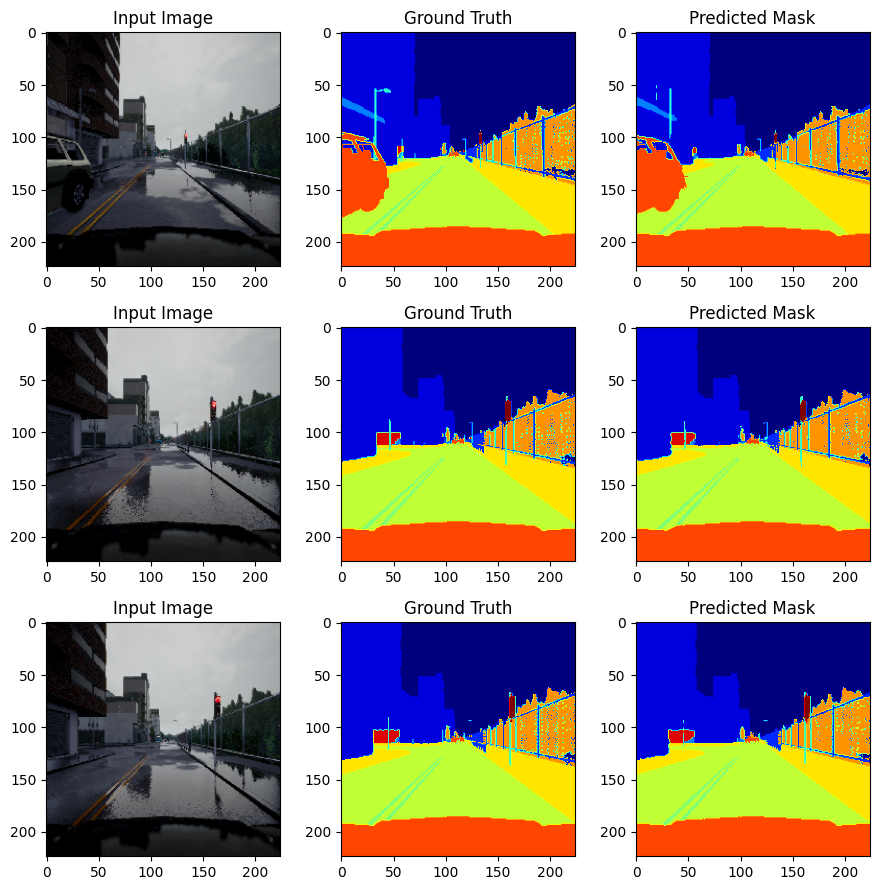

In [30]:
visualize_predictions(model_residual)

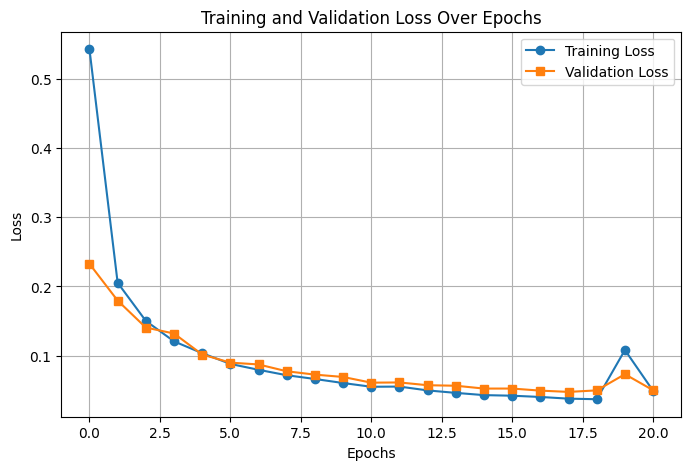

In [31]:
plot_losses(train_losses, val_losses)

In [32]:
evaluate_model(model_residual, test_loader)

Mean IoU on Test Set: 0.8986


1. Almost similar results to Vanilla U-net, most original details are preserved.

## Gated Attention

In [32]:
# Attention U-Net
model_attention = UNetVariants(n_channels=3, n_classes=13, bilinear=True, variant='attention').to(device)

In [33]:
train_losses, val_losses = train_model(model_attention, train_loader, val_loader, num_epochs = 50)

Epoch 1/50 | Train Loss: 0.9278 | Val Loss: 0.6259
Epoch 2/50 | Train Loss: 0.4921 | Val Loss: 0.3939
Epoch 3/50 | Train Loss: 0.3412 | Val Loss: 0.2954
Epoch 4/50 | Train Loss: 0.2594 | Val Loss: 0.2269
Epoch 5/50 | Train Loss: 0.2013 | Val Loss: 0.1811
Epoch 6/50 | Train Loss: 0.1648 | Val Loss: 0.1593
Epoch 7/50 | Train Loss: 0.1416 | Val Loss: 0.1352
Epoch 8/50 | Train Loss: 0.1228 | Val Loss: 0.1243
Epoch 9/50 | Train Loss: 0.1155 | Val Loss: 0.1346
No improvement in val loss for 1 epochs.
Epoch 10/50 | Train Loss: 0.1268 | Val Loss: 0.1311
No improvement in val loss for 2 epochs.
Epoch 11/50 | Train Loss: 0.1081 | Val Loss: 0.0944
Epoch 12/50 | Train Loss: 0.0858 | Val Loss: 0.0874
Epoch 13/50 | Train Loss: 0.0770 | Val Loss: 0.0797
Epoch 14/50 | Train Loss: 0.0705 | Val Loss: 0.0758
Epoch 15/50 | Train Loss: 0.0657 | Val Loss: 0.0708
Epoch 16/50 | Train Loss: 0.0618 | Val Loss: 0.0673
Epoch 17/50 | Train Loss: 0.0585 | Val Loss: 0.0671
Epoch 18/50 | Train Loss: 0.0560 | Val Loss

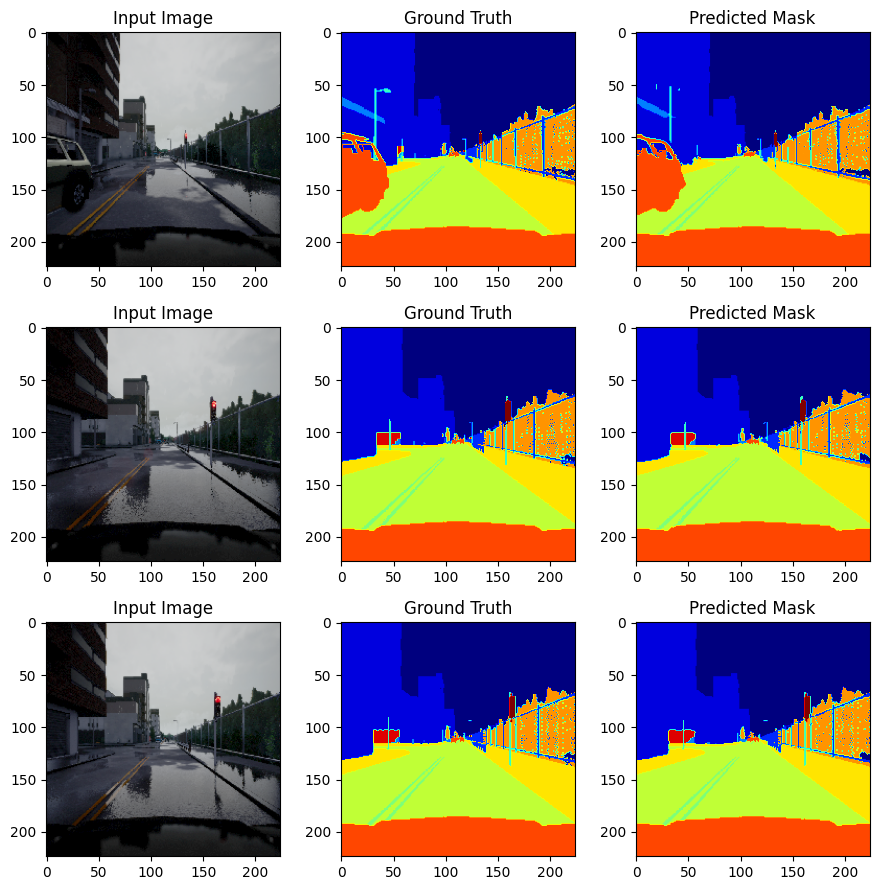

In [34]:
visualize_predictions(model_attention)

### 3.2.3 What is the impact of removing skip connections in U-Net?

1. Removing skip connections significantly degrades segmentation performance. 
2. In U-Net, skip connections are crucial for preserving high-resolution spatial information from the encoder and passing it directly to the decoder. 
3. Without these connections, the decoder is forced to reconstruct fine details using only the compressed bottleneck features, which often results in loss of detail.

- **No-skip U-Net** struggles to reconstruct fine-grained features, leading to lower Mean IoU and less precise segmentation masks.
Skip connections enhance model performance by enabling the decoder to access encoder-level details, making them essential for accurate semantic segmentation.


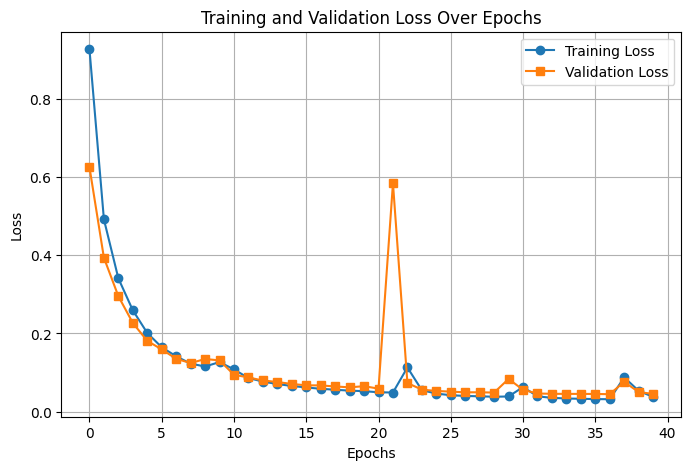

In [35]:
plot_losses(train_losses, val_losses)

In [1]:
evaluate_model(model_attention, test_loader)

Mean IoU on Test Set: 0.9079


In [2]:
!pip install tabulate


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd

# Data
data = {
    "Model Variant": ["Vanilla U-Net", "No Skip Connections", "Residual U-Net", "Attention U-Net"],
    "Mean IoU (Test Set)": [0.9053, 0.8295, 0.8986, 0.9079]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display
df.to_markdown(index=False)
df

Model Variant  Mean IoU (Test Set)
0        Vanilla U-Net               0.9053
1  No Skip Connections               0.8295
2       Residual U-Net               0.8986
3      Attention U-Net               0.9079

### Advantages of Using Attention Gates 

1. **Selective Feature Propagation**  
   Attention gates (AGs) learn to focus on relevant spatial features by suppressing irrelevant activations. This selective propagation means that only the most informative features from the encoder are passed to the decoder via skip connections.

2. **Improved Localization**  
   By generating attention maps, the model is better able to capture fine details and accurately delineate object boundaries. This results in more precise segmentation, especially for small or complex structures.

3. **Robustness to Variability**  
   The gating mechanism adapts to variations in shape, size, and appearance by dynamically weighting features. This makes the model more robust in scenarios where the objects of interest exhibit high variability.

4. **Minimal Computational Overhead**  
   Incorporating attention gates adds only a small amount of additional computation and parameters compared to the overall model, yet it leads to significant improvements in performance.



### How Does Gating at Skip Connections Help Improve Performance?

- **Refinement of High-Resolution Features:**  
  In a U-Net, skip connections transfer high-resolution features from the encoder to the decoder. Attention gates modulate these features, weighting them by their relevance. This allows the decoder to receive cleaner, more focused information, ultimately leading to better segmentation of fine structures.

- **Noise Suppression:**  
  The gating mechanism filters out irrelevant signals (noise) from the encoder features, reducing the propagation of extraneous information into the decoder. This results in fewer false positives and better overall segmentation accuracy.

- **Enhanced Gradient Flow:**  
  By emphasizing the salient features during forward propagation, attention helps maintain strong gradient signals during backpropagation. This can lead to faster convergence and improved model training.

---

### Observed Differences Compared to Standard U-Net Results

- **Sharper Segmentation Boundaries:**  
  The ability of AGs to focus on the important spatial regions leads to more precise and sharper object boundaries, reducing blurring and misclassification in areas where fine details matter.

In summary, the integration of attention gates refines the skip connection process by allowing the network to emphasize useful features and suppress irrelevant ones. This results in better localization, sharper boundaries, and overall improved segmentation performance compared to a standard U-Net.
